In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import numpy as np
import torchvision

In [3]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN,self).__init__()
        self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.bn1=nn.BatchNorm2d(32)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.bn3=nn.BatchNorm2d(128)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.fc1=nn.Linear(128*28*28,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256,6)
        self.dropout=nn.Dropout(0.5)
    
    def forward(self,x):
        x=self.pool(F.relu(self.bn1(self.conv1(x))))
        x=self.pool(F.relu(self.bn2(self.conv2(x))))
        x=self.pool(F.relu(self.bn3(self.conv3(x))))
        x=x.view(-1,128*28*28)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.relu(self.fc2(x))
        x=self.dropout(x)
        x=self.fc3(x)
        return x
    
model=CustomCNN()


In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [6]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [8]:
data_transforms_train=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

data_transforms_test=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

In [9]:
data_dir=r'F:\data' 

In [10]:
full_dataset=datasets.ImageFolder(root=data_dir,transform=data_transforms_train)

In [12]:
train_size=int(0.7*len(full_dataset))
val_size=int(0.15*len(full_dataset))
test_size=len(full_dataset)-train_size-val_size

train_data,val_data,test_data=torch.utils.data.random_split(full_dataset,[train_size,val_size,test_size])

In [13]:
train_data.dataset.transform=data_transforms_train
val_data.dataset.transform=data_transforms_train
test_data.dataset.transform=data_transforms_test

In [14]:
train_loader=DataLoader(dataset=train_data,shuffle=True,batch_size=64)
val_loader=DataLoader(dataset=val_data,shuffle=False,batch_size=64)
test_loader=DataLoader(dataset=test_data,shuffle=False,batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


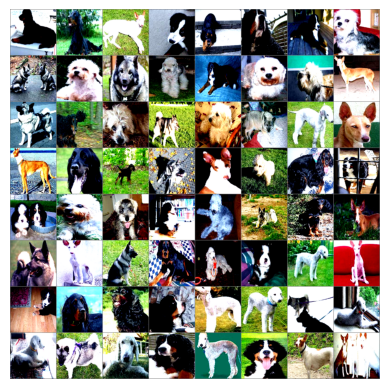

Gordon_setter Gordon_setter Ibizan_hound Bernese_mountain_dog Gordon_setter Bernese_mountain_dog Bernese_mountain_dog Dandie_Dinmont Norwegian_elkhound Dandie_Dinmont Norwegian_elkhound Bedlington_terrier Bernese_mountain_dog Dandie_Dinmont Dandie_Dinmont Ibizan_hound Norwegian_elkhound Gordon_setter Dandie_Dinmont Norwegian_elkhound Dandie_Dinmont Norwegian_elkhound Bedlington_terrier Ibizan_hound Ibizan_hound Gordon_setter Gordon_setter Norwegian_elkhound Ibizan_hound Dandie_Dinmont Gordon_setter Bernese_mountain_dog Bernese_mountain_dog Dandie_Dinmont Bedlington_terrier Bernese_mountain_dog Bedlington_terrier Norwegian_elkhound Gordon_setter Ibizan_hound Norwegian_elkhound Ibizan_hound Norwegian_elkhound Gordon_setter Bedlington_terrier Bernese_mountain_dog Bedlington_terrier Ibizan_hound Bernese_mountain_dog Gordon_setter Gordon_setter Bernese_mountain_dog Bedlington_terrier Bedlington_terrier Norwegian_elkhound Bedlington_terrier Bedlington_terrier Norwegian_elkhound Bedlington_te

In [15]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
class_names = train_loader.dataset.dataset.classes
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{class_names[labels[j]]}' for j in range(len(labels))))

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    model.train()  

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

       
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        model.eval()  
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

       
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        model.train()  

    return model


trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)


Epoch 1/20, Loss: 0.7648, Accuracy: 0.6977, Val Loss: 1.6042, Val Accuracy: 0.5089
Epoch 2/20, Loss: 0.6997, Accuracy: 0.6939, Val Loss: 1.4897, Val Accuracy: 0.4911
Epoch 3/20, Loss: 0.6910, Accuracy: 0.7281, Val Loss: 1.5827, Val Accuracy: 0.5179
Epoch 4/20, Loss: 0.7052, Accuracy: 0.7395, Val Loss: 1.5620, Val Accuracy: 0.4821
Epoch 5/20, Loss: 0.6882, Accuracy: 0.7338, Val Loss: 1.4597, Val Accuracy: 0.5089
Epoch 6/20, Loss: 0.6548, Accuracy: 0.7319, Val Loss: 1.3981, Val Accuracy: 0.6071
Epoch 7/20, Loss: 0.7189, Accuracy: 0.7110, Val Loss: 1.4776, Val Accuracy: 0.5179
Epoch 8/20, Loss: 0.7195, Accuracy: 0.6996, Val Loss: 1.5153, Val Accuracy: 0.5089
Epoch 9/20, Loss: 0.6517, Accuracy: 0.7129, Val Loss: 1.5475, Val Accuracy: 0.5089
Epoch 10/20, Loss: 0.6780, Accuracy: 0.7224, Val Loss: 1.7444, Val Accuracy: 0.5268
Epoch 11/20, Loss: 0.6172, Accuracy: 0.7624, Val Loss: 1.5596, Val Accuracy: 0.5179
Epoch 12/20, Loss: 0.6180, Accuracy: 0.7510, Val Loss: 1.6352, Val Accuracy: 0.4911
E

In [22]:
def test_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print(f'Test Accuracy: {test_acc:.4f}')


test_model(trained_model, test_loader)

Test Accuracy: 0.5702
